# Building a song recommender

In [1]:
%matplotlib inline

import pandas
from sklearn.cross_validation import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import Recommenders as Recommenders
import Evaluation as Evaluation

C:\WinPython-64bit-3.5.2.3Qt5\python-3.5.2.amd64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load music data

In [2]:
#Read userid-songid-listen_count triplets
#This step might take time to download data from external sources
triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

song_df_1 = pandas.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_df_2 =  pandas.read_csv(songs_metadata_file)

#Merge the two dataframes above to create input dataframe for recommender systems
song_df = pandas.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left") 

In [3]:
print(song_df_1.head())
len(song_df_1)

                                    user_id             song_id  listen_count
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995             1
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B             2
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBXHDL12A81C204C0             1
3  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBYHAJ12A6701BF1D             1
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SODACBL12A8C13C273             1


2000000

In [4]:
song_df_2.head()
len(song_df_2)
print(song_df_2.head(5))
len(song_df)
print(song_df.head(5))

              song_id              title  \
0  SOQMMHC12AB0180CB8       Silent Night   
1  SOVFVAK12A8C1350D9        Tanssi vaan   
2  SOGTUKN12AB017F4F1  No One Could Ever   
3  SOBNYVR12A8C13558C      Si Vos Querés   
4  SOHSBXH12A8C13B0DF   Tangle Of Aspens   

                                release       artist_name  year  
0                 Monster Ballads X-Mas  Faster Pussy cat  2003  
1                           Karkuteillä  Karkkiautomaatti  1995  
2                                Butter    Hudson Mohawke  2006  
3                               De Culo       Yerba Brava  2003  
4  Rene Ablaze Presents Winter Sessions        Der Mystic     0  
                                    user_id             song_id  listen_count  \
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995             1   
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B             2   
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBXHDL12A81C204C0             1   
3  b80344d063b5

# Explore data

Music data shows how many times a user listened to a song, as well as the details of the song.

In [5]:
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


## Length of the dataset

In [6]:
len(song_df)
song_df = song_df.head(10000)
len(song_df)

10000

## Create a subset of the dataset

In [7]:
song_df = song_df.head(10000)

#Merge song title and artist_name columns to make a merged column
song_df['song'] = song_df['title'].map(str) + " - " + song_df['artist_name']

## Showing the most popular songs in the dataset

In [8]:
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
3660,Sehr kosmisch - Harmonia,45,0.45
4678,Undo - Björk,32,0.32
5105,You're The One - Dwight Yoakam,32,0.32
1071,Dog Days Are Over (Radio Edit) - Florence + Th...,28,0.28
3655,Secrets - OneRepublic,28,0.28
4378,The Scientist - Coldplay,27,0.27
4712,Use Somebody - Kings Of Leon,27,0.27
3476,Revelry - Kings Of Leon,26,0.26
1387,Fireflies - Charttraxx Karaoke,24,0.24
1862,Horn Concerto No. 4 in E flat K495: II. Romanc...,23,0.23


## Count number of unique users in the dataset

In [9]:
users = song_df['user_id'].unique()

In [10]:
len(users)

365

## Quiz 1. Count the number of unique songs in the dataset

In [11]:
###Fill in the code here
songs = song_df['song'].unique()
len(songs)

5151

# Create a song recommender

In [12]:
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)
print(train_data.head(5))

                                       user_id             song_id  \
7389  94d5bdc37683950e90c56c9b32721edb5d347600  SOXNZOW12AB017F756   
9275  1012ecfd277b96487ed8357d02fa8326b13696a5  SOXHYVQ12AB0187949   
2995  15415fa2745b344bce958967c346f2a89f792f63  SOOSZAZ12A6D4FADF8   
5316  ffadf9297a99945c0513cd87939d91d8b602936b  SOWDJEJ12A8C1339FE   
356   5a905f000fc1ff3df7ca807d57edb608863db05d  SOAMPRJ12A8AE45F38   

      listen_count                 title  \
7389             2      Half Of My Heart   
9275             1  The Beautiful People   
2995             1     Sanctify Yourself   
5316             4     Heart Cooks Brain   
356             20                 Rorol   

                                                release      artist_name  \
7389                                     Battle Studies       John Mayer   
9275             Antichrist Superstar (Ecopac Explicit)   Marilyn Manson   
2995                             Glittering Prize 81/92     Simple Minds   
5316  Ever

## Simple popularity-based recommender class (Can be used as a black box)

### Create an instance of popularity based recommender class

In [13]:
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

### Use the popularity model to make some predictions

In [14]:
user_id = users[20]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,0afaa5d9d04bf85af720fe8cc566a41ca3e41c97,Sehr kosmisch - Harmonia,37,1.0
4083,0afaa5d9d04bf85af720fe8cc566a41ca3e41c97,Undo - Björk,27,2.0
931,0afaa5d9d04bf85af720fe8cc566a41ca3e41c97,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,0afaa5d9d04bf85af720fe8cc566a41ca3e41c97,You're The One - Dwight Yoakam,24,4.0
3034,0afaa5d9d04bf85af720fe8cc566a41ca3e41c97,Revelry - Kings Of Leon,21,5.0
3189,0afaa5d9d04bf85af720fe8cc566a41ca3e41c97,Secrets - OneRepublic,21,6.0
4112,0afaa5d9d04bf85af720fe8cc566a41ca3e41c97,Use Somebody - Kings Of Leon,21,7.0
1207,0afaa5d9d04bf85af720fe8cc566a41ca3e41c97,Fireflies - Charttraxx Karaoke,20,8.0
1577,0afaa5d9d04bf85af720fe8cc566a41ca3e41c97,Hey_ Soul Sister - Train,19,9.0
1626,0afaa5d9d04bf85af720fe8cc566a41ca3e41c97,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


In [15]:
user_id = users[7]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Sehr kosmisch - Harmonia,37,1.0
4083,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Undo - Björk,27,2.0
931,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,You're The One - Dwight Yoakam,24,4.0
3034,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Revelry - Kings Of Leon,21,5.0
3189,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Secrets - OneRepublic,21,6.0
4112,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Use Somebody - Kings Of Leon,21,7.0
1207,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Fireflies - Charttraxx Karaoke,20,8.0
1577,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Hey_ Soul Sister - Train,19,9.0
1626,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


### Quiz 2: Use the popularity based model to make predictions for the following user id (Note the difference in recommendations from the first user id).

In [16]:
###Fill in the code here
user_id = users[8]
pm.recommend(user_id)


,user_id,song,score,Rank
3194,9bb911319fbc04f01755814cb5edb21df3d1a336,Sehr kosmisch - Harmonia,37,1.0
4083,9bb911319fbc04f01755814cb5edb21df3d1a336,Undo - Björk,27,2.0
931,9bb911319fbc04f01755814cb5edb21df3d1a336,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,9bb911319fbc04f01755814cb5edb21df3d1a336,You're The One - Dwight Yoakam,24,4.0
3034,9bb911319fbc04f01755814cb5edb21df3d1a336,Revelry - Kings Of Leon,21,5.0
3189,9bb911319fbc04f01755814cb5edb21df3d1a336,Secrets - OneRepublic,21,6.0
4112,9bb911319fbc04f01755814cb5edb21df3d1a336,Use Somebody - Kings Of Leon,21,7.0
1207,9bb911319fbc04f01755814cb5edb21df3d1a336,Fireflies - Charttraxx Karaoke,20,8.0
1577,9bb911319fbc04f01755814cb5edb21df3d1a336,Hey_ Soul Sister - Train,19,9.0
1626,9bb911319fbc04f01755814cb5edb21df3d1a336,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


## Build a song recommender with personalization

We now create an item similarity based collaborative filtering model that allows us to make personalized recommendations to each user. 

## Class for an item similarity based personalized recommender system

### Create an instance of item similarity based recommender class

In [17]:
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

### Use the personalized model to make some song recommendations

In [18]:
#Print the songs for the user in training data
user_id = users[5]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 4bd88bfb25263a75bbdd467e74018f4ae570e5df:
------------------------------------------------------------------------------------
Just Lose It - Eminem
Without Me - Eminem
16 Candles - The Crests
Speechless - Lady GaGa
Push It - Salt-N-Pepa
Ghosts 'n' Stuff (Original Instrumental Mix) - Deadmau5
Say My Name - Destiny's Child
My Dad's Gone Crazy - Eminem / Hailie Jade
The Real Slim Shady - Eminem
Somebody To Love - Justin Bieber
Forgive Me - Leona Lewis
Missing You - John Waite
Ya Nada Queda - Kudai
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 13
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2097


,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Superman - Eminem / Dina Rae,0.088692,1.0
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird - Eminem,0.067663,2.0
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm Back - Eminem,0.065385,3.0
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,U Smile - Justin Bieber,0.064525,4.0
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Here Without You - 3 Doors Down,0.062293,5.0
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hellbound - J-Black & Masta Ace,0.055769,6.0
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,The Seed (2.0) - The Roots / Cody Chestnutt,0.052564,7.0
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm The One Who Understands (Edit Version) - War,0.052564,8.0
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Falling - Iration,0.052564,9.0
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Armed And Ready (2009 Digital Remaster) - The ...,0.052564,10.0


### Quiz 3. Use the personalized model to make recommendations for the following user id. (Note the difference in recommendations from the first user id.)

In [19]:
user_id = users[7]
#Fill in the code here
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)


------------------------------------------------------------------------------------
Training data songs for the user userid: 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec:
------------------------------------------------------------------------------------
Swallowed In The Sea - Coldplay
Life In Technicolor ii - Coldplay
Life In Technicolor - Coldplay
The Scientist - Coldplay
Trouble - Coldplay
Strawberry Swing - Coldplay
Lost! - Coldplay
Clocks - Coldplay
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 8
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :3429


,user_id,song,score,rank
0,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,She Just Likes To Fight - Four Tet,0.281579,1.0
1,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Warning Sign - Coldplay,0.281579,2.0
2,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,We Never Change - Coldplay,0.281579,3.0
3,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Puppetmad - Puppetmastaz,0.281579,4.0
4,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,God Put A Smile Upon Your Face - Coldplay,0.281579,5.0
5,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Susie Q - Creedence Clearwater Revival,0.281579,6.0
6,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,The Joker - Fatboy Slim,0.281579,7.0
7,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Korg Rhythm Afro - Holy Fuck,0.281579,8.0
8,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,This Unfolds - Four Tet,0.281579,9.0
9,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,high fives - Four Tet,0.281579,10.0


### We can also apply the model to find similar songs to any song in the dataset

In [20]:
is_model.get_similar_items(['U Smile - Justin Bieber'])

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :271


,user_id,song,score,rank
0,,Somebody To Love - Justin Bieber,0.428571,1.0
1,,Bad Company - Five Finger Death Punch,0.375000,2.0
2,,Love Me - Justin Bieber,0.333333,3.0
3,,One Time - Justin Bieber,0.333333,4.0
4,,Here Without You - 3 Doors Down,0.333333,5.0
5,,Stuck In The Moment - Justin Bieber,0.333333,6.0
6,,Teach Me How To Dougie - California Swag District,0.333333,7.0
7,,Paper Planes - M.I.A.,0.333333,8.0
8,,Already Gone - Kelly Clarkson,0.333333,9.0
9,,The Funeral (Album Version) - Band Of Horses,0.300000,10.0


In [21]:
song = 'Yellow - Coldplay'
###Fill in the code here
is_model.get_similar_items([song])

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :969


,user_id,song,score,rank
0,,Fix You - Coldplay,0.375000,1.0
1,,Creep (Explicit) - Radiohead,0.291667,2.0
2,,Clocks - Coldplay,0.280000,3.0
3,,Seven Nation Army - The White Stripes,0.250000,4.0
4,,Paper Planes - M.I.A.,0.208333,5.0
5,,Halo - Beyoncé,0.200000,6.0
6,,The Funeral (Album Version) - Band Of Horses,0.181818,7.0
7,,In My Place - Coldplay,0.181818,8.0
8,,Kryptonite - 3 Doors Down,0.166667,9.0
9,,When You Were Young - The Killers,0.166667,10.0


## Quantitative comparison between the models

In [22]:
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:319
Length of user sample:15
Getting recommendations for user:99b5f915dd56a0150eb91605e1f6109e1e80c9de
No. of unique songs for the user: 14
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :1421
Getting recommendations for user:a54543f7282b66b3c8423181bf2789e1c7eb2edc
No. of unique songs for the user: 10
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :1014
Getting recommendations for user:14903f6491e335f4c5f9c42573d700e7ade59c5e
No. of unique songs for the user: 2
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :61
Getting recommendations for user:2c218a60b3d777e9e12d56c2e065a9644b5e5f41
No. of unique songs for the user: 2
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :83
Getting recommendations for user:8bc2733e75989c8de36cf1bb596dabfd72734e86
No. of unique songs for the user: 7
no. of unique songs in the tra

In [23]:
import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.2])
    pl.xlim([0.0, 0.2])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()

Plotting precision recall curves.


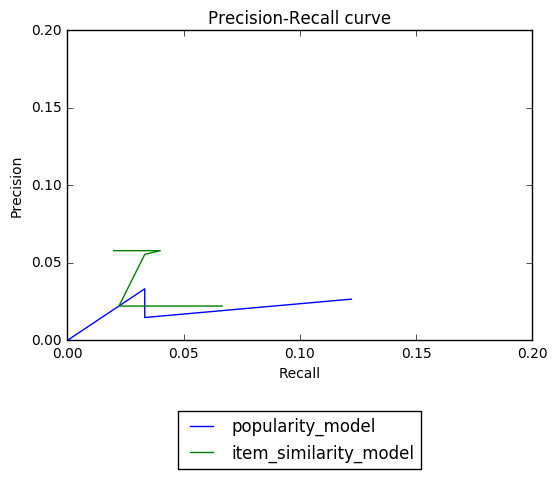

In [24]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")